# Representation Analysis

In [1]:
import torch

#@markdown Execute this cell to check the Colab environment, including GPU availability.

# check gpu env
print(f"Torch: {torch.__version__} \n" + 
      f"Availability: {torch.cuda.is_available()}")
assert torch.cuda.is_available() == True, "The GPU is turned off. To turn it on, navigate to: Runtime > Change Runtime Type."
print(f"Number: {torch.cuda.device_count()} \n" +
      f"Current device: {torch.cuda.current_device()} \n" +
      f"First device: {torch.cuda.device(0)} \n" +
      f"Device name: {torch.cuda.get_device_name(0)}")

Torch: 2.7.0.dev20250122+cu126 
Availability: True
Number: 1 
Current device: 0 
First device: <torch.cuda.device object at 0x7a327471ba30> 
Device name: NVIDIA GeForce RTX 4060 Ti


In [2]:
import os
import math
import numpy as np
from torch.utils.data import DataLoader

import torchvision.datasets as datasets
import timm.data.transforms_factory as tff
from src.models.components.cl_vs_mim.utils import subsample

#@markdown Execute this cell to download and import the *Imagenette* dataset, which is a small subset of ImageNet, for simplicity.

# use imagenette (a small subset of imagenet) as an example for simplicity
imagenet_path = "~/development/datasets/imagenette2-160"

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

transform_test = tff.transforms_imagenet_eval(
    img_size=224, mean=imagenet_mean, std=imagenet_std,
)

test_dir = os.path.join(imagenet_path, 'val')
dataset_test = datasets.ImageFolder(test_dir, transform_test)
dataset_test = torch.utils.data.Subset(
    dataset_test, 
    subsample(dataset_test, ratio=math.pow(2,-6))  # use a subsampled batch
)

dataset_test = DataLoader(
    dataset_test, 
    num_workers=1, 
    batch_size=64,
)

## Load the Models

In [ ]:
def load_moco():
    import src.models.components.cl_vs_mim.moco as moco
    from src.models.components.cl_vs_mim.moco  import load_state_dict
    from src.models.components.cl_vs_mim.utils import download
    path = "../../artifacts/moco_vit_b.pt"  #@param {type:"string"}
    url = "https://dl.fbaipublicfiles.com/moco-v3/vit-b-300ep/vit-b-300ep.pth.tar"  #@param {type:"string"}

    download(url, path, force=False)  # download checkpoints

    model = moco.vit_base()
    model = model.cuda()
    model = model.eval()

    state_dict = load_state_dict(path)
    _ = model.load_state_dict(state_dict, strict=False)
    return model

In [ ]:
# SimMIM 
def load_simmmim():
    import src.models.components.cl_vs_mim.simmim as simmim
    from src.models.components.cl_vs_mim.simmim import load_state_dict
    path = "../../artifacts/simmim_vit_b.pth"  #@param {type:"string"}
    model = simmim.vit_base("../../src/models/components/cl_vs_mim/simmim_pretrain__vit_base__img224__800ep.yaml")
    model = model.cuda()
    model = model.eval()

    state_dict = load_state_dict(path)
    _ = model.load_state_dict(state_dict, strict=False)
    return model

In [5]:
def load_part():
    from src.models.components.cl_vs_mim.vit import VisionTransformer
    from functools import partial
    from torch import nn as nn
    path = "../../artifacts/model-ukjrb3lq:v0/epoch=41-step=52584_backbone.ckpt"  #@param {type:"string"}
    model = VisionTransformer(  
        patch_size=16, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6))

    model = model.cuda()
    model = model.eval()
    out = model.load_state_dict(torch.load(path), strict=False)
    print(out)
    return model

In [6]:
def load_mae():
    from src.models.components.cl_vs_mim.vit import VisionTransformer
    from functools import partial
    from torch import nn as nn
    import timm
    from timm.models.vision_transformer import VisionTransformer as timm_vit
    model_mae = timm.create_model('vit_base_patch16_224.mae', pretrained=True)
    # dump state dict

    model = VisionTransformer(
        patch_size=16, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6)
    )
    model = model.cuda()
    model = model.eval()
    out = model.load_state_dict(model_mae.state_dict(), strict=False)
    print(out)
    return model_mae



## Fourier Analysis

In [7]:
# build off the implementation of https://github.com/xxxnell/how-do-vits-work
import matplotlib.pyplot as plt
from einops import rearrange, reduce, repeat
from timm.utils import AverageMeter

def fourier(x):
    """2D Fourier transform"""
    f = torch.fft.fft2(x)
    f = f.abs() + 1e-6
    f = f.log()
    return f

def shift(x):  
    """shift Fourier transformed feature map"""
    b, c, h, w = x.shape
    return torch.roll(x, shifts=(int(h/2), int(w/2)), dims=(2, 3))

def get_fourier_latents(latents):
    """Fourier transform feature maps"""
    fourier_latents = []
    for latent in latents:  # `latents` is a list of hidden feature maps in latent spaces
        latent = latent.cpu()
        b, n, c = latent.shape
        h, w = int(math.sqrt(n)), int(math.sqrt(n))
        latent = rearrange(latent, "b (h w) c -> b c h w", h=h, w=w)
        
        latent = fourier(latent)
        latent = shift(latent).mean(dim=(0, 1))
        latent = latent.diag()[int(h/2):]  # only use the half-diagonal components
        latent = latent - latent[0]  # visualize 'relative' log amplitudes 
                                     # (i.e., low-freq amp - high freq amp)
        fourier_latents.append(latent)

    return fourier_latents
    
#@markdown Execute this cell to conduct Fourier analysis. The y-axis shows the amplitude (magnitude) of the high-frequency information. 
#@markdown 
#@markdown The results show that CL (MoCo) mainly exploits low-frequency information whereas MIM (SimMIM) exploits high-frequency information.

model_option = "moco"  #@param ["moco", "simmim"]
if model_option == "moco":
    model = model_moco
elif model_option == "simmim":
    model = model_simmim
else:
    raise Exception("Invalid option: ", model_option)

fourier_latents = AverageMeter()
for i, (xs, ys) in enumerate(dataset_test):
    with torch.no_grad():
        xs = xs.cuda()
        _, zs, _, _ = model(xs)
        zs = zs[:-1]

    latents = [z[:,1:,:] for z in zs]
    _fourier_latents = torch.stack(get_fourier_latents(latents))
    fourier_latents.update(_fourier_latents)

    if i > -1:
        break
        
fig, ax = plt.subplots(1, 1, figsize=(4.2, 4), dpi=150)
fourier_latents = fourier_latents.avg
ax.plot(range(13), fourier_latents[:,-1][::2], marker="o")
ax.set_xlabel("Depth")
ax.set_ylabel("$\Delta$ Log amplitude")
ax.set_ylim(top=-1.5, bottom=-3.5)
plt.show()

NameError: name 'model_moco' is not defined

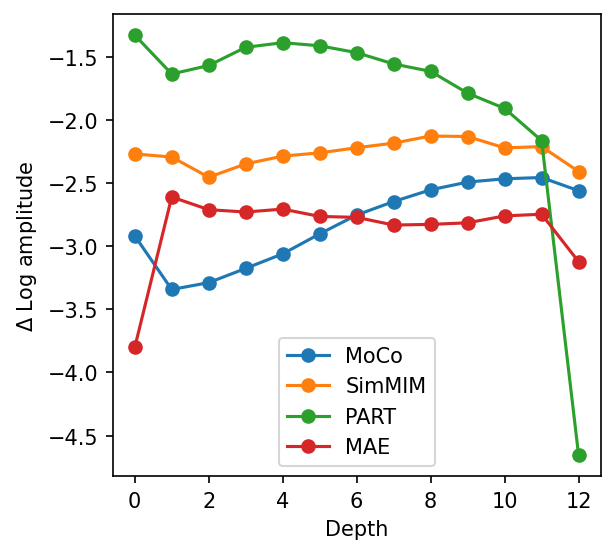

In [12]:
# build off the implementation of https://github.com/xxxnell/how-do-vits-work
import matplotlib.pyplot as plt
from einops import rearrange, reduce, repeat
from timm.utils import AverageMeter

def fourier(x):
    """2D Fourier transform"""
    f = torch.fft.fft2(x)
    f = f.abs() + 1e-6
    f = f.log()
    return f

def shift(x):  
    """shift Fourier transformed feature map"""
    b, c, h, w = x.shape
    return torch.roll(x, shifts=(int(h/2), int(w/2)), dims=(2, 3))

def get_fourier_latents(latents):
    """Fourier transform feature maps"""
    fourier_latents = []
    for latent in latents:  # `latents` is a list of hidden feature maps in latent spaces
        latent = latent.cpu()
        b, n, c = latent.shape
        h, w = int(math.sqrt(n)), int(math.sqrt(n))
        latent = rearrange(latent, "b (h w) c -> b c h w", h=h, w=w)
        
        latent = fourier(latent)
        latent = shift(latent).mean(dim=(0, 1))
        latent = latent.diag()[int(h/2):]  # only use the half-diagonal components
        latent = latent - latent[0]  # visualize 'relative' log amplitudes 
                                     # (i.e., low-freq amp - high freq amp)
        fourier_latents.append(latent)

    return fourier_latents

fig, ax = plt.subplots(1, 1, figsize=(4.2, 4), dpi=150)

models = {
    "MoCo": model_moco,
    "SimMIM": model_simmim,
    "PART": model_part,
    "MAE": model_mae,
}


for label, model in models.items():
    fourier_latents = AverageMeter()
    for i, (xs, ys) in enumerate(dataset_test):
        with torch.no_grad():
            xs = xs.cuda()
            _, zs, _, _ = model(xs)
            zs = zs[:-1]

        latents = [z[:,1:,:] for z in zs]
        _fourier_latents = torch.stack(get_fourier_latents(latents))
        fourier_latents.update(_fourier_latents)

        if i > -1:
            break
            
    fourier_latents = fourier_latents.avg
    ax.plot(range(13), fourier_latents[:,-1][::2], marker="o", label=label)

ax.set_xlabel("Depth")
ax.set_ylabel("$\Delta$ Log amplitude")
# ax.set_ylim(top=-3, bottom=-3.5)
ax.legend()
plt.show()


## Toekn-level t-SNE Visualization

/tmp/ipykernel_40720/1407869445.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  def visualize_token_tsne(ax, zs, depth, ys, cmap=cm.get_cmap("plasma")):
/home/dgcnz/development/thesis/PART/.venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


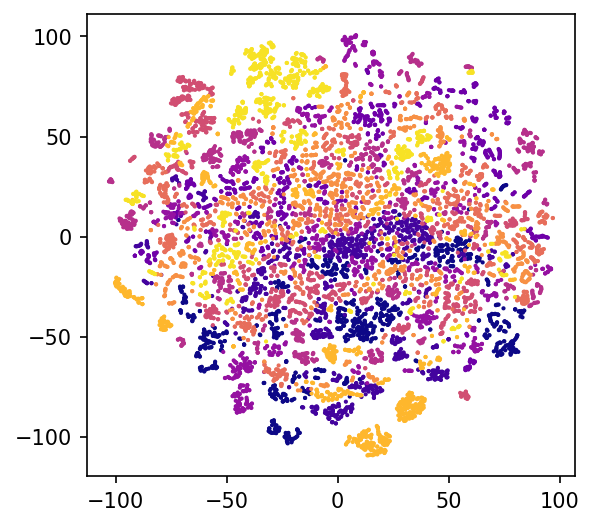

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.manifold import TSNE
from einops import rearrange, reduce, repeat

def visualize_token_tsne(ax, zs, depth, ys, cmap=cm.get_cmap("plasma")): 
    latents = zs[depth]
    latents = latents[:,1:,:]  # drop cls
    latents = rearrange(latents, "b n c -> (b n) c",)
    latents = latents.cpu()

    reducer = TSNE(n_components=2, perplexity=20, learning_rate='auto', init='random', n_iter=1000)
    embedded = reducer.fit_transform(latents)
    
    labels = ys 
    labels = np.array([[label] * 196 for label in labels]).flatten()
    c = [cmap(label / (max(labels) + 0.5)) for label in labels]
    
    ax.scatter(embedded[:,0], embedded[:,1], c=c, s=1)
    
#@markdown Execute this cell to visualize token-level representations by using t-SNE. Note that we visualize 3,528 tokens (196 tokens×18 images) from the representations. 
#@markdown 
#@markdown The tokens of MoCo form a cluster for each image, while those of SimMIM are intermingled. This aligns with the finding that, compared to SimMIM, MoCo is linearly separable. The colors represent three different classes.

model_option = "moco"  #@param ["moco", "simmim"]
depth = 10  #@param {type:"slider", min:0, max:11, step:1}
if model_option == "moco":
    model = model_moco
elif model_option == "simmim":
    model = model_simmim
else:
    raise Exception("Invalid option: ", model_option)

xs, ys = next(iter(dataset_test))
with torch.no_grad():
    xs = xs.cuda()
    _, zs, _, _ = model(xs)
    zs = zs[:-1]

fig, ax = plt.subplots(1, 1, figsize=(4.2, 4), dpi=150)
visualize_token_tsne(ax, zs, depth=depth, ys=ys)  # coloring at the image level